## Ajouter des personnes pour rendre le model plus performant 

 ## Librairies

 - La librairie `cv2` permet la détection automatique de visages, entre autres.

 - La librairie `pickle` permet de sauvegarder vos modèles une fois entraînés, et de les recharger pour pouvoir les utiliser.

In [116]:
import os

import cv2
import pickle

import numpy as np

import matplotlib.pyplot as plt


 ## Création du dataset

À la différence du dataset précédent, les viages ne sont plus identifiés par leur noms mais par leur classe. La classe `1` concerne les membres admis et la classe `0` ceux qui ne sont pas admis. **À chaque fois que vos relancez le code ci-dessous, votre caméra capture 10 images de la personne qui se trouve devant vootre PC et ajoute ces dernières à votre dataset (Vous aurez au préalable à renseigner sa classe)**


 Le code effectue les opérations suivantes. Premièrement, on lit le flux vidéo de votre caméra et on détecte automatiquement les visages dans chaque image de ce flux en utilisant le **classificateur en cascade de Haar (Haar cascade classifier)** de la librairie `OpenCV`.

 Plus précisément, tant que la variable `ret` est vraie, indiquant que le flux vidéo est lu correctement, pour chaque image capturée par la caméras, on effectue les opérations suivantes:
 1. on convertit l'image en niveaux de gris;
 2. on détecte les coordonnées du visage en utilisant le classificateur en cascade de Haar;
 3. on recadre la région du visage et la redimensionne en $50 \times 50$ pixels;
 4. on ajoute l'image du visage redimensionné à la liste `donnees_visage`, à chaque intervalle de $10$ images.

 Une fois que $10$ images de votre visage ont été collecteés, ou si l'utilisateur appuye sur la touche `Esc`, on met fin à la boucle et enregistre les images dans la liste `donnees_visage` sous forme d'un tableau `NumPy`.



 Par la suite, l'existence des fichiers `targets.pkl` et `features.pkl` est vérifiée. S'ils n'existent pas, de nouveaux fichiers sont créés, la variable `admission_state` renseigne la classe `y` des `x` photos enregistées, les targets (classe des différents visages) sont enregistrées dans  `targets.pkl` et les données de visage (features) sont enregistrées dans `features.pkl`. Si ces fichiers existent déjà, le code charge les données existantes, ajoute les nouvelles données de visage et classe, et les réenregistre le tout dans les fichiers respectifs.

 L'idée de ce notebook est de peupler notre dataset, en effet, plus nous avons de donnéees, plus la reconnaissance du modèle sera accrus. J'ai alors eu l'idée de rajouter un dataset trouver sur Kaggle (https://www.kaggle.com/datasets/atulanandjha/lfwpeople?resource=download), une section sera alors rajouter à ce notebook concernant le traitement de ces nouvelles images afin de les rajouter (pour ne pas trop surcharger la chose, seul, un petit partie du dataset a été utilisé)

In [117]:

# ================== #
# Variables globales #
# ================== #
if not os.path.exists("data_binary_classification"):
    os.mkdir("data_binary_classification")         # création d'un répertoire data

nb_images_collectees = 20    # nombre d'image que vous voulez collecter

donnees_visage = []

camera = cv2.VideoCapture(0) # 0 pour 'built-in' caméra, 1 pour caméra externe

cascade_visage = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# ====================================== #
# Capture des data: images et classes    #
# ====================================== #

ret = True
i = 0

while(ret):
    ret, frame = camera.read()
    
    if ret == True:
        gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        coordonnees_visage = cascade_visage.detectMultiScale(gris, 1.3, 4)

        for (a, b, w, h) in coordonnees_visage:
            features = frame[b:b+h, a:a+w, :]
            visages_redimensionnes = cv2.resize(features, (50, 50))
            
            if i % 10 == 0 and len(donnees_visage) < nb_images_collectees:
                donnees_visage.append(visages_redimensionnes)
                
            cv2.rectangle(frame, (a, b), (a+w, b+h), (255, 0, 0), 2)
            
        i += 1

        cv2.imshow('Visages', frame)

        if cv2.waitKey(1) == 27 or len(donnees_visage) >= nb_images_collectees:
            break
    else:
        print('erreur')
        break

cv2.destroyAllWindows()
camera.release()

donnees_visage = np.asarray(donnees_visage)


# ======================================= #
# Enregistrement des data: nom et images  #
# ======================================= #
if 'targets.pkl' not in os.listdir('data_binary_classification/'):
    admission_state = 1
    targets = [admission_state] * nb_images_collectees
    with open('data_binary_classification/targets.pkl', 'wb') as file:
        pickle.dump(targets, file) # Comme le fichier n'existe pas, on part du principe que les visages font partie de la classe admis
else:
    choix_admission = input("Voulez-vous ajouter ces visages en tant qu'admis? (o/n): ")
    if choix_admission == 'o':
        with open('data_binary_classification/targets.pkl', 'rb') as file:
            targets = pickle.load(file)
        admission_state = 1
        targets = np.concatenate([targets, [admission_state] * nb_images_collectees])
        with open('data_binary_classification/targets.pkl', 'wb') as file:
            pickle.dump(targets, file)
    else:
        admission_state = 0
        with open('data_binary_classification/targets.pkl', 'rb') as file:
            
            targets = pickle.load(file)
        targets = np.concatenate([targets, [admission_state] * nb_images_collectees])
        with open('data_binary_classification/targets.pkl', 'wb') as file:
            pickle.dump(targets, file)

# Redimensionner les images collectées pour les mettre à la même dimension que les images existantes
donnees_visage_redimensionnees = np.array([cv2.resize(img, (50, 50)) for img in donnees_visage])

if 'features.pkl' not in os.listdir('data_binary_classification/'):
    features = donnees_visage_redimensionnees
    with open('data_binary_classification/features.pkl', 'wb') as w:
        pickle.dump(features, w)
else:
    with open('data_binary_classification/features.pkl', 'rb') as w:
        features = pickle.load(w)

    # Utilisation de np.concatenate pour ajouter les nouvelles valeurs à la fin du tableau existant
    features = np.concatenate([features, donnees_visage_redimensionnees], axis=0)

    with open('data_binary_classification/features.pkl', 'wb') as w:
        pickle.dump(features, w)

cv2.destroyAllWindows()




ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 4 dimension(s)

In [ ]:
if not os.path.exists("data_binary_classification"):
     os.mkdir("data_binary_classification")

if 'features.pkl' not in os.listdir('data_binary_classification/'):
    features = []
    targets = []
    for root, dirs, files in os.walk('mini_data'):
        for file in files:
            if file.endswith('.jpg'):
                img = cv2.imread(root + '/' + file)
                img = cv2.resize(img, (50, 50))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                features.append(img)
                targets.append(0)

                break

    features = np.asarray(features)
    targets = np.asarray(targets)
    with open('data_binary_classification/features.pkl', 'wb') as w:
        pickle.dump(features, w)
    with open('data_binary_classification/targets.pkl', 'wb') as w:
        pickle.dump(targets, w)
else:
    with open('data_binary_classification/features.pkl', 'rb') as w:
        features = pickle.load(w)
    with open('data_binary_classification/targets.pkl', 'rb') as w:
        targets = pickle.load(w)
    for root, dirs, files in os.walk('mini_data'):
        for file in files:
            if file.endswith('.jpg'):
                img = cv2.imread(root + '/' + file)
                img = cv2.resize(img, (50, 50))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                features = np.append(features, img)
                targets = np.append(targets, [0], axis=0)
    with open('data_binary_classification/features.pkl', 'wb') as w:
        pickle.dump(features, w)
    with open('data_binary_classification/targets.pkl', 'wb') as w:
        pickle.dump(targets, w)

 ## Visualisation du dataset

 Le instructions suivantes permettent de loader votre dataset et de comprendre comment sont stockées les data.

 Prêtez attention aux types de vos data, en particulier à la dimension de vos images, etc.

In [ ]:
with open("data_binary_classification/targets.pkl", "rb") as fh:
    targets = pickle.load(fh)


In [ ]:
targets

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [ ]:
with open("data_binary_classification/features.pkl", "rb") as fh:
    features = pickle.load(fh)


In [ ]:
features.shape
features = features.reshape(-1, 50, 50, 1)
features.shape


(23, 50, 50, 1)

In [ ]:
sample_1 = features[0]
sample_1.shape

(50, 50, 1)

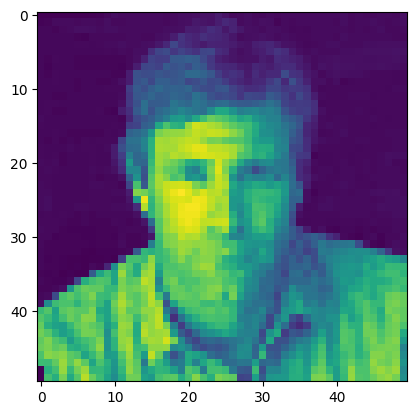

In [ ]:
plt.imshow(sample_1, interpolation="nearest")


In [ ]:
sample_2 = features[5]
sample_2.shape


(50, 50)

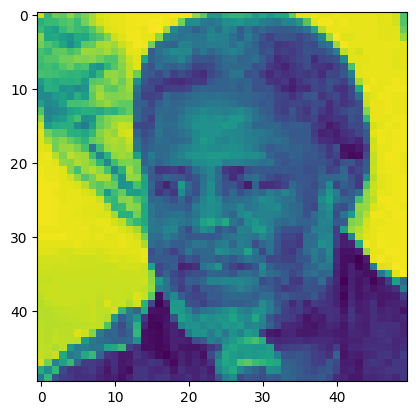

In [ ]:
plt.imshow(sample_2, interpolation="nearest")




IndexError: index 23 is out of bounds for axis 0 with size 23

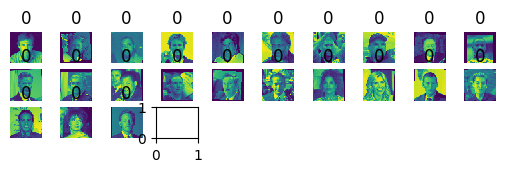

In [ ]:
# afficher toute les images avec leur classe associée

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(features[i], interpolation="nearest")
    plt.title(targets[i])
    plt.axis("off")
plt.show()